In [124]:
import pandas as pd
import geopandas as geopd
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
path = r'*.gz'
folder = glob.glob(path)

for file in folder:
    print(file)

calendar.csv.gz
listings.csv.gz
reviews.csv.gz


In [73]:
calendar_df = pd.read_csv('calendar.csv.gz', compression='gzip')
listings_df = pd.read_csv('listings.csv.gz', compression='gzip')
reviews_df = pd.read_csv('reviews.csv.gz', compression='gzip')

C:\Users\jcoet\AppData\Local\conda\conda\envs\mine\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
# return listings which are relevant to location data

location_listings_df = listings_df[['id', 'street',
             'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
             'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
             'latitude', 'longitude', 'is_location_exact']]

In [75]:
def get_cat_columns(df):
    
    cat_cols = []
    
    for col in df.columns:
        
        # include column if it's categories are lower than 30
        if len(df[col].value_counts()) < 30:
            cat_cols.append(col)
            
        # include column if it's numeric
        elif col in list(listings_df.select_dtypes(include=['float', 'int']).columns):
            cat_cols.append(col)
            
        # include column if it's in property details
        elif col in list(location_listings_df.columns):
            cat_cols.append(col)
    
    # ensure all duplicates are removed        
    cat_cols = list(set(cat_cols))
        
    return df[cat_cols]

In [76]:
listings_df = get_cat_columns(listings_df)

In [77]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [78]:
def remove_dollar(value):
    value = value.replace('$', '')
    value = value.replace(',', '')
    return float(value)

<h2>1. When are the most popular times to hike up the price?</h2>

In [79]:
calendar_df['adjusted_price'] = calendar_df['adjusted_price'].apply(remove_dollar)
calendar_df['price'] = calendar_df['price'].apply(remove_dollar)

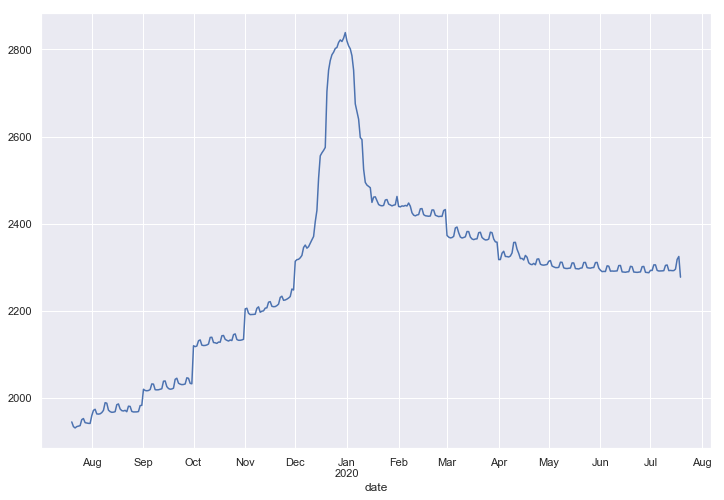

In [80]:
calendar_df['adjusted_price'].groupby(calendar_df['date']).mean().plot(figsize=(12, 8))

In [105]:
available_df = calendar_df[calendar_df['available'] == 't']
not_available_df = calendar_df[calendar_df['available'] == 'f']

In [110]:
available_df['adjusted_price'].mean() - not_available_df['adjusted_price'].mean()

191.19861026579702

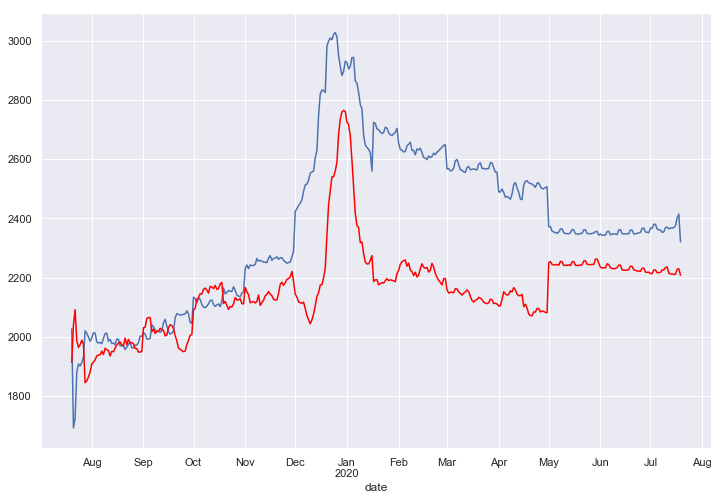

In [82]:
available_df['adjusted_price'].groupby(available_df['date']).mean().plot(figsize=(12, 8))
not_available_df['adjusted_price'].groupby(not_available_df['date']).mean().plot(figsize=(12, 8),
                                                                                 color='red')

In [83]:
def get_listing_mean(listing_id):
    return calendar_df[calendar_df['listing_id'] == listing_id]['adjusted_price'].mean()

def get_listing_min(listing_id):
    return calendar_df[calendar_df['listing_id'] == listing_id]['adjusted_price'].min()

def get_listing_max(listing_id):
    return calendar_df[calendar_df['listing_id'] == listing_id]['adjusted_price'].max()

In [84]:
price_df = calendar_df['listing_id'].value_counts().reset_index()
price_df.columns = ['listing_id', 'days_available']

In [85]:
price_df['mean_price'] = price_df['listing_id'].apply(get_listing_mean)

In [86]:
price_df['min_price'] = price_df['listing_id'].apply(get_listing_min)

In [87]:
price_df['max_price'] = price_df['listing_id'].apply(get_listing_max)

In [88]:
price_df.drop('days_available', axis=1, inplace=True)

<h2>2. Which areas are the most expensive?</h2>

In [89]:
price_df = pd.read_csv('price_df.csv')

In [90]:
df = pd.merge(listings_df, price_df, left_on='id', right_on='listing_id')
df.dropna(how='all', axis=1, inplace=True)

In [91]:
def get_ward_mean(ward_name):
    return df[df['neighbourhood_cleansed'] == ward_name]['mean_price'].mean()

In [92]:
df['ward_mean'] = df['neighbourhood_cleansed'].apply(get_ward_mean)

In [93]:
ward_mean_df = df[['neighbourhood_cleansed', 'ward_mean']]
ward_mean_df.columns = ['ward', 'ward_mean']
ward_mean_df.drop_duplicates(subset='ward', inplace=True)

C:\Users\jcoet\AppData\Local\conda\conda\envs\mine\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
ward_geo = geopd.read_file('neighbourhoods.geojson')

In [95]:
wards = pd.merge(ward_geo, ward_mean_df,
                 left_on='neighbourhood',
                right_on='ward')

wards.drop(['neighbourhood_group', 'neighbourhood'], axis=1, inplace=True)

In [96]:
# One ward's mean was an anomaly and had to be removed 

wards = wards.sort_values('ward_mean', ascending=False).drop(23)

In [97]:
folium_map = folium.Map(location=[-33.9249, 18.4241],
               zoom_start=9.6)

In [98]:
# Add colour fill for municipality boundaries layer

folium.Choropleth(
    geo_data=ward_geo,
    data=wards,
    columns=['ward', 'ward_mean'],
    key_on= 'properties.neighbourhood',
    fill_color='RdYlBu',
    line_opacity=0.2,
    nan_fill_color='#ff845e'
).add_to(folium_map)

In [99]:
folium_map

<h2>3. What contributes most to the price of listings?</h2>

In [100]:
corr_df = df.corr().sort_values('mean_price', ascending=False)['mean_price'].reset_index()
corr_df.columns = ['feature', 'corr']
corr_df['corr_abs'] = corr_df['corr'].abs()

In [101]:
corr_df = corr_df.sort_values('corr_abs', ascending=False).head(20)

In [102]:
format_dict = {'sum':'${0:,.0f}', 'date': '{:%m-%Y}', 'pct_of_total': '{:.2%}'}

In [103]:
(corr_df
 .style
 .format(format_dict)
 .hide_index()
 .bar(color='lightgreen', subset=['corr_abs'], align='zero')
 .set_caption('Biggest correlations with listings price'))

feature,corr,corr_abs
mean_price,1,1
min_price,0.96729,0.96729
max_price,0.897887,0.897887
bathrooms,0.404503,0.404503
accommodates,0.376341,0.376341
square_feet,0.350909,0.350909
bedrooms,0.346591,0.346591
license,0.324624,0.324624
ward_mean,0.300714,0.300714
beds,0.265295,0.265295


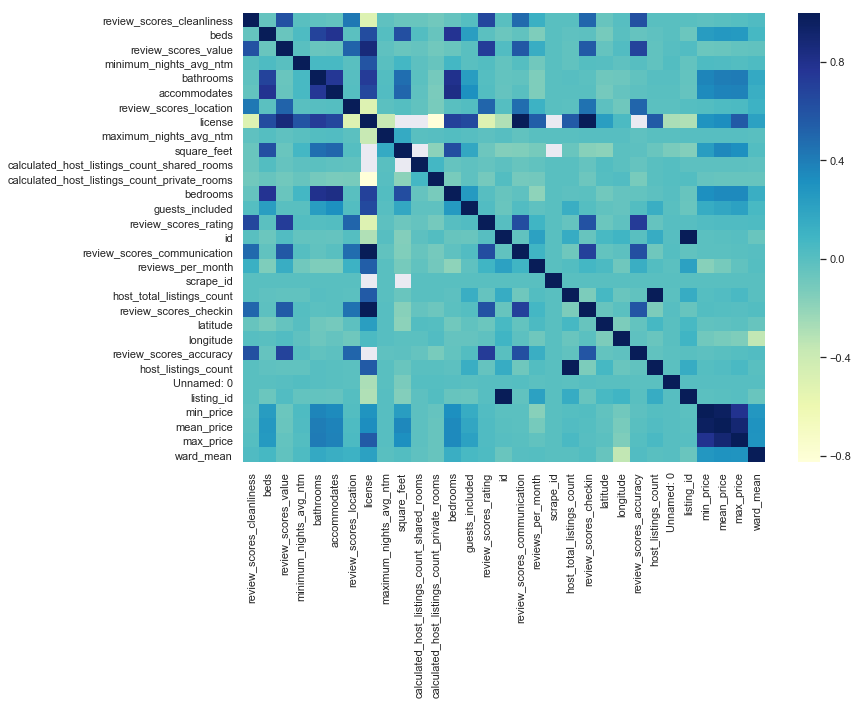

In [125]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(df.corr(), cmap="YlGnBu", ax=ax)

In [118]:
df.sort_values('mean_price', ascending=False)[['neighbourhood_cleansed',
                                               'smart_location',
                                               'mean_price', 'bathrooms',
                                               'accommodates', 'square_feet',
                                               'bedrooms', 'guests_included',
                                               'listing_id'
                                              ]].head(10)

,neighbourhood_cleansed,smart_location,mean_price,bathrooms,accommodates,square_feet,bedrooms,guests_included,listing_id
22378,Ward 74,"Hout Bay , South Africa",300000.000000,1.5,4,NaN,1.0,2,35597310
16212,Ward 54,"Cape Town, South Africa",252739.726027,6.0,12,NaN,6.0,12,27367686
14917,Ward 54,"Cape Town, South Africa",161260.273973,6.0,12,NaN,6.0,12,24230850
22389,Ward 74,"Hout Bay, South Africa",150000.000000,1.5,1,NaN,1.0,1,35634993
22032,Ward 54,"Cape Town, South Africa",147000.000000,6.0,12,NaN,6.0,1,35212572
14927,Ward 54,"Cape Town, South Africa",146712.328767,6.0,10,NaN,6.0,10,24231503
22464,Ward 106,"Cape Town, South Africa",144788.000000,1.0,2,NaN,2.0,1,35795956
11243,Ward 100,"Cape Town, South Africa",140000.000000,0.0,1,NaN,0.0,1,20444799
6,Ward 115,"Cape Town, South Africa",125000.000000,1.0,2,NaN,1.0,3,15199
15004,Ward 54,"Cape Town, South Africa",106356.164384,4.0,8,NaN,4.0,8,24349838


In [119]:
df.sort_values('mean_price', ascending=True)[['neighbourhood_cleansed',
                                               'smart_location',
                                               'mean_price', 'bathrooms',
                                               'accommodates', 'square_feet',
                                               'bedrooms', 'guests_included',
                                               'listing_id'
                                              ]].head(10)

,neighbourhood_cleansed,smart_location,mean_price,bathrooms,accommodates,square_feet,bedrooms,guests_included,listing_id
21172,Ward 11,"Cape Town, South Africa",127.920548,1.0,1,NaN,1.0,1,33738120
10317,Ward 11,"Cape Town , South Africa",131.000000,1.0,1,NaN,1.0,1,18442126
10580,Ward 11,"Kuils River, South Africa",131.000000,1.5,1,NaN,1.0,1,18973684
5250,Ward 54,"Cape Town, South Africa",132.000000,2.5,8,NaN,4.0,1,11348030
16499,Ward 64,"Cape Town, South Africa",138.443836,1.0,1,NaN,1.0,1,27919539
4195,Ward 115,"Cape Town, South Africa",139.000000,1.0,2,NaN,1.0,1,9748745
549,Ward 43,"Cape Town, South Africa",140.000000,3.0,16,NaN,12.0,1,2081369
21347,Ward 43,"Cape Town, South Africa",145.000000,5.0,16,NaN,14.0,1,34033564
19594,Ward 115,"Cape Town, South Africa",145.178082,3.0,4,NaN,1.0,1,31558004
19596,Ward 115,"Cape Town, South Africa",145.561644,3.0,4,NaN,1.0,1,31558609
